# Ziv-Lempel Compression Algorithm

#### Dependencies

In [555]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Internal Functions

In [556]:
def necessarybits(N, B=0):
    while 2**B < N: B+=1
    return B

def binblock(n, B):
    def binary(n): 
        return binary(int(n/2)) + str(n%2) if n else ''
    b = binary(n)
    if len(b)>B: print('FATAL ERROR! ',n,'overflows',B,'bit buffer.')
    else: return '0'*(B-len(b)) + b

def decimal(s):
    x = 0
    for k in range(0,len(s)):
        x += (2**k) * int(s[-k-1])
    return x  

#### Metrics

In [1425]:
def entropy(sample):
    p0 = float(sample.count('0'))/len(sample)
    p1 = float(sample.count('1'))/len(sample)
    if p0 and p1:
        return - math.log2(p0)*p0 - math.log2(p1)*p1
    else:
        return 0

#### Sample Generators

In [1218]:
def randomsample(size, p, s=''):
    for i in range(size):
        s += '1' if random.random()<p else '0'
    return s

def splitpattern(size, p, k=1, s=''):
    block = size/k
    for i in range(k):
        s += int(p*block)*'1'
        s += int((1-p)*block)*'0'
    return s

def text_to_bin(txt,B=8,s=''):
    for char in txt: s += binblock(ord(char),8)
    return s

def bin_to_text(s,B=8,txt=''):
    for ci in range(0,len(s),B): txt += chr(decimal(s[ci:ci+B]))
    return txt

#### Stream Plotter

In [857]:
def plotStream(ax, s, verbose=False):
    N = len(s)
    if verbose : print('*** Plotting Stream of size',N)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    for c in range(len(s)):
        if s[c]!='0':
            ax.axvspan(c, c+1,color='k',lw=0,alpha=0.8)

## LZ : Fixed Library Encoding (Vanilla)

In [99]:
def LZ_encode(source, verbose=False, debug=False):
    N = len(source)
    if verbose: print('\n*** LZ Encoding',N,'bits.')
    D, Seq, C, win = ['0','1'], [], 0, 1
    while C+win<=N:
        s = source[C:C+win]
        if s in D :
            pred = D.index(s)
            win+=1
        else:
            D.append(s)
            Seq.append([pred,s[-1]])
            C += win
            win=1 
            
    tail = source[C:]
    if len(tail) : Seq.append([D.index(tail),''])
    B = necessarybits(len(D))  
    if debug:
        print('Encoder Library =',D)
        print('Sequence =',Seq)
        print('Residual Size =',len(tail))
        print('Library Size =',len(D),' (',B,'bits )')
        
    code = ''
    for s in Seq:
        code += binblock(s[0],B)+s[1]
    return code, B       

In [100]:
def LZ_decode(code, B=8, verbose=False, debug=False):
    N = len(code)
    if verbose: print('\n*** LZ Decoding',N,'bits.')
    D, M, C = ['0','1'],'',0
    while C+B<N:
        pred,last = code[C:C+B],code[C+B]
        index = decimal(pred)
        D.append(D[index]+last)
        M += D[index]+last
        C += B+1
    tail = code[C:]
    if len(tail) : M += D[decimal(tail)]
    if debug: print('Decoder Library =',D)     
    return M

#### Unit Test (LZ)

In [489]:
sample = randomsample(1000000,0.9)
output = False
debug = False
code, B = LZ_encode(sample, debug=debug)
if output: print('S :',sample,'\nC :',code)
print('Compression :',len(sample),'>>',len(code))
M = LZ_decode(code, B, debug=debug)
if output: print('O :',M)
print('Unit Test :', 'Passed' if (M==sample) else 'Failed')

Compression : 1000000 >> 623168
Unit Test: Passed


## LZW : Width Adaptation

In [331]:
def LZW_encode(source, verbose=False, debug=False):
    N = len(source)
    if verbose: print('*** LZW Encoding',N,'bits.')
    B, D, Seq, C, win, code = 2, ['0','1'], [], 0, 1, ''
    while C + win <= N:
        s = source[C:C+win]
        if debug: print('>(%d,%d) %s'%(C,win,s))
        if s in D :
            pred = D.index(s)
            win += 1
        else:
            D.append(s)
            Seq.append([pred,s[-1]])
            code += binblock(pred,B)+s[-1]
            if debug:
                print('L :',D)
                print('Seq :',Seq)
                print('Code :',code)
            C += win
            win = 1
            if B < necessarybits(len(D)+1):
                B += 1
                if debug: print('Library Bits >>',B)
                
    tail = source[C:]
    if len(tail) : 
        code += binblock(D.index(tail),B)
        
    if debug:
        print('Encoder Library =',D)
        print('Sequence =',Seq)
        print('Tail =',tail)
        
    return code   

In [352]:
def LZW_decode(code, verbose=False, debug=False):
    N = len(code)
    if verbose: print('*** LZW Decoding',N,'bits.')
    B, D, M, C = 2, ['0','1'],'',0
    while C+B+1<=N:
        pred,last = code[C:C+B],code[C+B]
        if debug: print('>(%d,%d) %s'%(C,C+B+1,code[C:C+B+1]))
        pred,last = code[C:C+B],code[C+B]
        index = decimal(pred)
        D.append(D[index]+last)
        M += D[index]+last
        if debug: 
            print('Seq :',index,last)
            print('L :',D)
            print('M :',M)
        C += B+1
        if B < necessarybits(len(D)+1):
            B += 1
            if debug: print('Library Bits >>',B)
  
    tail = code[C:]
    if len(tail): 
        M += D[decimal(tail)]
    
    if debug:
        print('Tail :',tail)
        print('Decoder Library =',D)     
    return M

#### Unit Test (LZW)

In [648]:
sample = randomsample(5000000,0.5)
output = False
debug = False
if output: print('S :',sample)
code = LZW_encode(sample,verbose=output,debug=debug)
if output: print('CODE :',code)
print('Compression :',len(sample),'>>',len(code))
M = LZW_decode(code,verbose=output,debug=debug)
if output: print('M :',M)
print('Unit Test :', 'Passed' if (M==sample) else 'Failed')

Compression : 5000000 >> 5539329
Unit Test : Passed


# Analyses
### Input Length and Compression
#### LZ vs LZW (Input Length Test at max Entropy)

In [1078]:
SampleSize = range(10**4,120*10**4+1,10**4)
N = len(SampleSize)
CR_length1 = np.zeros(N)
CR_length2 = np.zeros(N)

print('Testing',N,'samples',end = ' >> ')
for s in range(N):
    print(s+1,end='.')
    sample = randomsample(SampleSize[s],0.5)
    M, B = LZ_encode(sample)
    CR_length1[s] = len(M)/len(sample)
    M = LZW_encode(sample)
    CR_length2[s] = len(M)/len(sample) 

Testing 120 samples >> 1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.

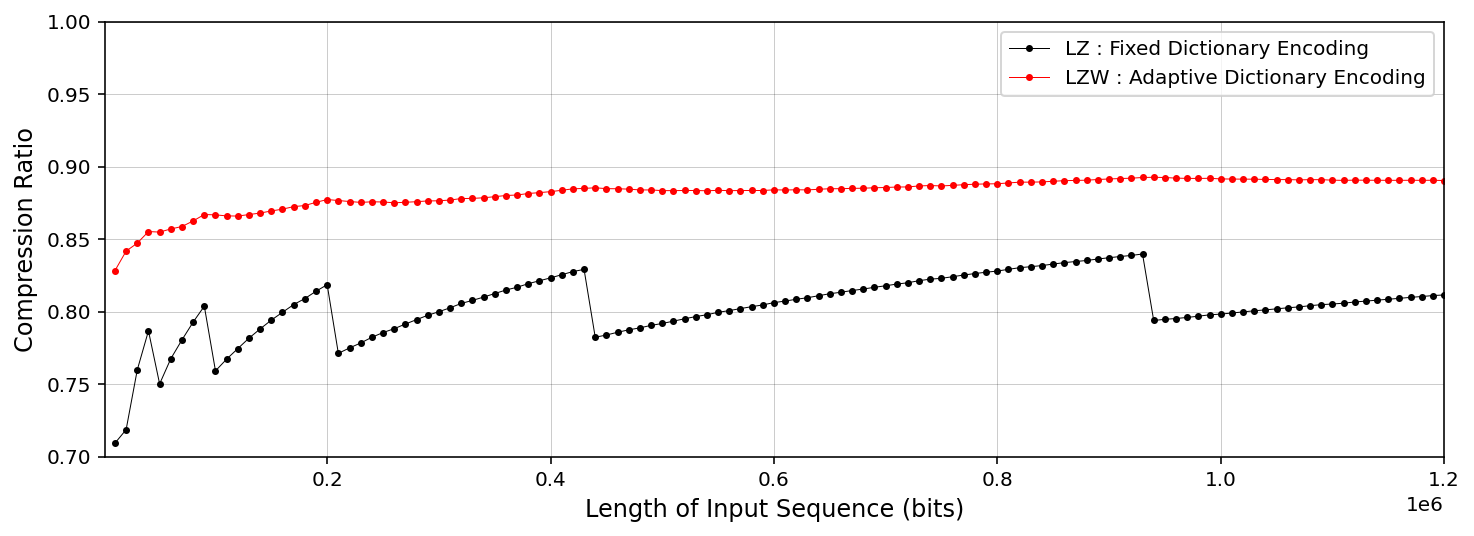

In [1110]:
plt.figure(figsize=(12,4))
plt.xlim(10**3,12*10**5)
plt.ylim(0.7,1)
plt.xlabel('Length of Input Sequence (bits)',size=12)
plt.ylabel('Compression Ratio',size=12)
plt.plot(SampleSize, 1/CR_length1, '-k.',label='LZ : Fixed Dictionary Encoding',ms=5,lw=.5)
plt.plot(SampleSize, 1/CR_length2, '-r.',label='LZW : Adaptive Dictionary Encoding',ms=5,lw=.5)
plt.gca().grid(alpha=0.2,color='k', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig('SequenceVSCompression.png',dpi=120)
plt.show()


### Entropy and Compression

#### LZ vs LZW (Random Bitstream Test)

In [547]:
samplesize = 1000000
prange = np.arange(0.0,0.5,0.005)
NN = len(prange)

E = np.zeros(NN)
CL1 = np.zeros(NN)
CL2 = np.zeros(NN)
print('Testing',NN,'samples',end = ' >> ')
for i in range(NN):
    print(i+1,end='.')
    sample = randomsample(samplesize,prange[i])
    E[i] += entropy(sample)
    CL1[i] += len(LZ_encode(sample)[0])/float(samplesize)
    CL2[i] += len(LZW_encode(sample))/float(samplesize)


Testing 100 samples >> 1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.

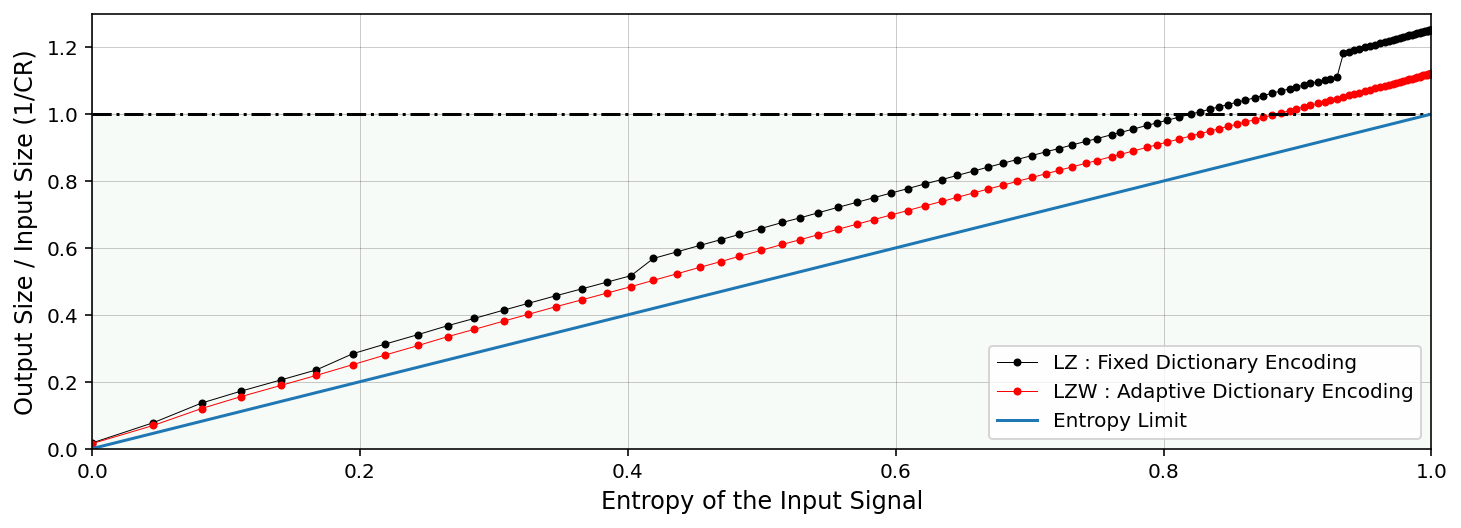

In [810]:
plt.figure(figsize=(12,4))
plt.ylabel('Output Size / Input Size (1/CR)',size=12)
plt.xlabel('Entropy of the Input Signal',size=12)
plt.plot(E,CL1,'-k.',label='LZ : Fixed Dictionary Encoding',lw=0.5)
plt.plot(E,CL2,'-r.',label='LZW : Adaptive Dictionary Encoding',lw=0.5)
plt.xlim(0,1)
plt.ylim(0,1.3)
plt.axhline(1,ls='-.',color='k')
plt.gca().axhspan(0, 1, alpha=0.03, color='green')
plt.gca().grid(alpha=0.2,color='k', linestyle='-', linewidth=0.5)
plt.plot([0,1],[0,1],label='Entropy Limit')

plt.legend(loc='lower right')
plt.savefig('LZvariantsEntropyCompression.png',dpi=120)
plt.show()

### Patterns vs Noise / Breaking Entropy Limit

#### Bitstream Representation

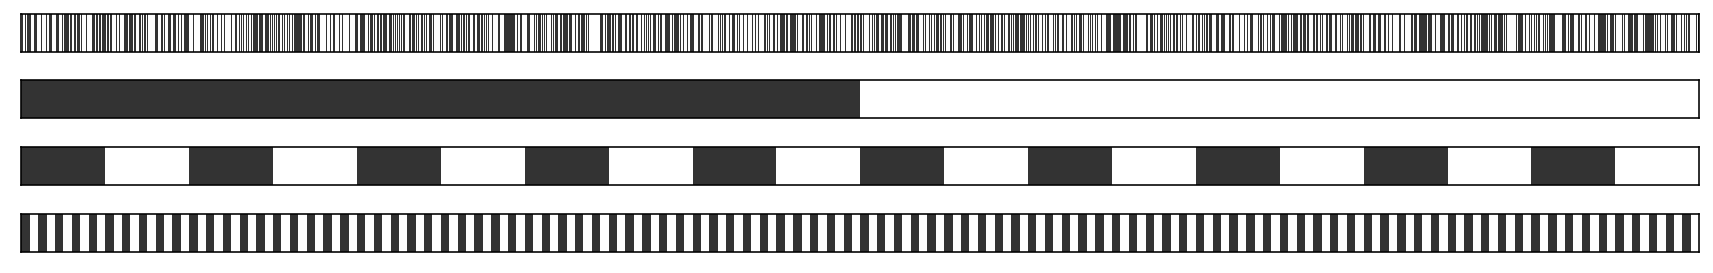

In [1043]:
length = 10**5
p, k = 0.5, [1,10,100]
K = len(k)
fig = plt.figure(figsize=(12,2))
fig.subplots(K+1,1,sharex=True)
ax = plt.subplot(K+1,1,1)
s = randomsample(length,p)
plt.xlim(0,len(s))
plotStream(ax, s)
for i in range(0,K):
    s = splitpattern(length,p,k[i])
    ax = plt.subplot(K+1,1,i+2)
    plt.xlim(0,len(s))
    plotStream(ax, s)
plt.tight_layout()
plt.savefig('Patterns_P%d.png'%int(p*100),dpi=120)
plt.show()

#### Entropy Scan for Pattern & Noise

In [1053]:
size = 10**5
P = np.arange(0,0.45,0.005)
N = len(P)
CLZW_ran = np.empty(N)
CLZW_pat1 = np.empty(N)
CLZW_pat2 = np.empty(N)
CLZW_pat3 = np.empty(N)
EnR = np.empty(N)
EnP1 = np.empty(N)
EnP2 = np.empty(N)
EnP3 = np.empty(N)

print('Testing',N,'samples >> ',end='')
for i in range(N):
    print(i+1,end='.')             
    s = randomsample(size,P[i])
    EnR[i] = entropy(s)
    CLZW_ran[i] = len(LZW_encode(s))/size         
    s = splitpattern(size,P[i],1)
    EnP1[i] = entropy(s)
    CLZW_pat1[i] = len(LZW_encode(s))/size               
    s = splitpattern(size,P[i],10)
    CLZW_pat2[i] = len(LZW_encode(s))/size
    EnP2[i] = entropy(s)
    s = splitpattern(size,P[i],100)
    CLZW_pat3[i] = len(LZW_encode(s))/size
    EnP3[i] = entropy(s)
    

Testing 90 samples >> 1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.

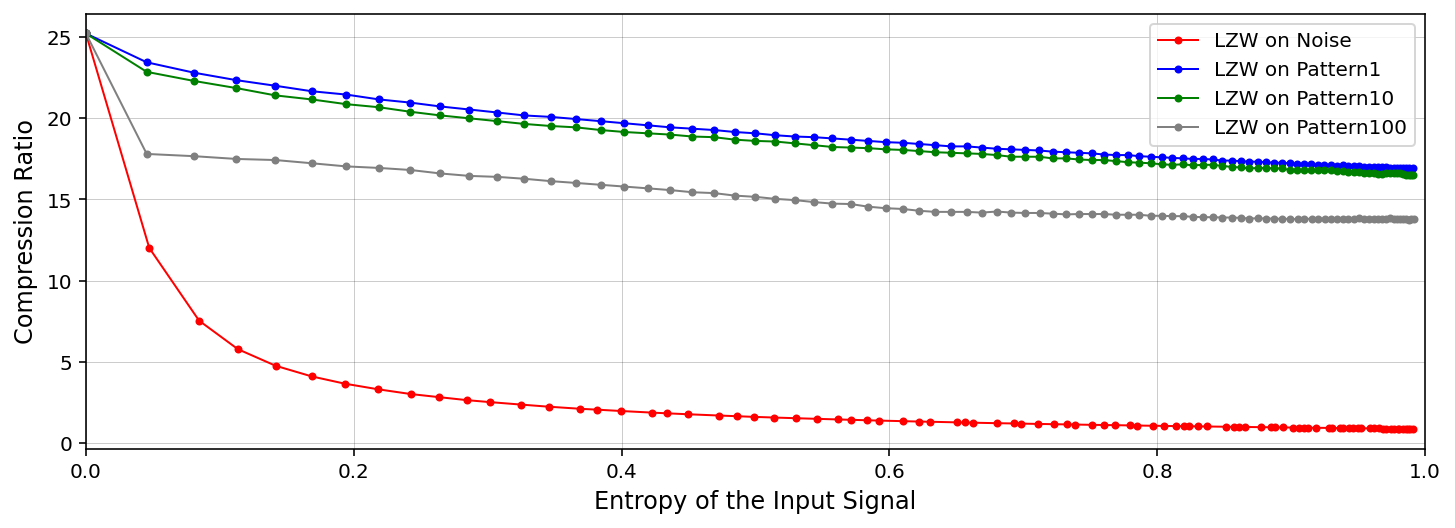

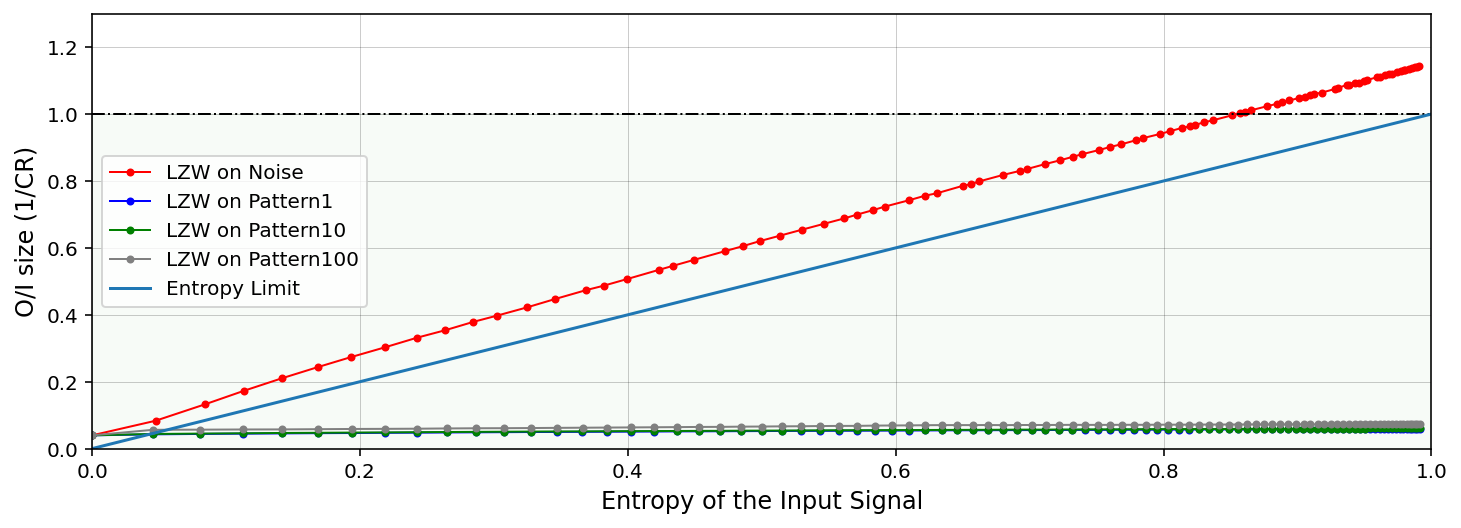

In [1059]:
plt.figure(figsize=(12,4))
plt.xlim(0,1)
plt.xlabel('Entropy of the Input Signal',size=12)
plt.ylabel('Compression Ratio',size=12)
plt.plot(EnR,1/CLZW_ran,'-',color='red', marker='.',label='LZW on Noise',lw=1)
plt.plot(EnP1,1/CLZW_pat1,'-',color='blue',marker='.',label='LZW on Pattern1',lw=1)
plt.plot(EnP2,1/CLZW_pat2,'-',color='green',marker='.',label='LZW on Pattern10',lw=1)
plt.plot(EnP3,1/CLZW_pat3,'-',color='gray',marker='.',label='LZW on Pattern100',lw=1)
plt.gca().grid(alpha=0.2,color='k', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig('Patterns_CR.png',dpi=120)
plt.show()

plt.figure(figsize=(12,4))
plt.xlim(0,1)
plt.ylim(0,1.3)
plt.xlabel('Entropy of the Input Signal',size=12)
plt.ylabel('O/I size (1/CR)',size=12)
plt.plot(EnR,CLZW_ran,'-',color='red', marker='.',label='LZW on Noise',lw=1)
plt.plot(EnP1,CLZW_pat1,'-',color='blue',marker='.',label='LZW on Pattern1',lw=1)
plt.plot(EnP2,CLZW_pat2,'-',color='green',marker='.',label='LZW on Pattern10',lw=1)
plt.plot(EnP3,CLZW_pat3,'-',color='gray',marker='.',label='LZW on Pattern100',lw=1)
plt.axhline(1,ls='-.',color='k',lw=1)
plt.gca().axhspan(0, 1, alpha=0.03, color='green')
plt.plot([0,1],[0,1], label='Entropy Limit')
plt.gca().grid(alpha=0.2,color='k', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig('Patterns_OI.png',dpi=120)
plt.show()

### Over-compression Test

In [1239]:
samplesize = 100000
sample = splitpattern(samplesize,0.1,100)
OC = 20
comp = [1]
ent = [entropy(sample)]
for k in range(1,OC):
    sample = LZW_encode(sample)
    comp.append(len(sample)/samplesize)
    ent.append(entropy(sample))
    if len(sample)>1.5*samplesize: break

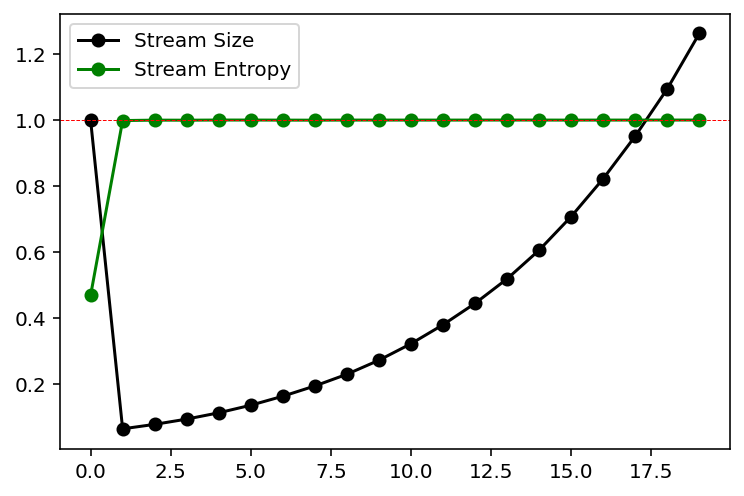

In [1240]:
plt.plot(comp,'-ok',label='Stream Size')
plt.plot(ent,'-og',label='Stream Entropy')
plt.axhline(1,color='r',ls='--',lw=0.5)
plt.legend()
plt.show()

## Text Compression

#### Unit Test: A Study in Scarlet

In [1250]:
sampletext = open("Scarlet.txt", "r").read()
samplebin = text_to_bin(sampletext)
sample_entropy = entropy(samplebin)
print(len(sampletext),'bytes file >',len(samplebin),'bit source with Entropy = %.4f'%sample_entropy)
code = LZW_encode(samplebin, verbose=True)
print(int(len(code)/8), 'bytes code / Compression : %.4f'%(len(samplebin)/len(code)))
decodedtxt = bin_to_text(LZW_decode(code,verbose=True))
print('Unit Test :', 'Passed' if decodedtxt==sampletext else 'Failed')

260087 bytes file > 2080696 bit source with Entropy = 0.9829
*** LZW Encoding 2080696 bits.
183876 bytes code / Compression : 1.4145
*** LZW Decoding 1471015 bits.
Unit Test : Passed


In [1427]:
print(decodedtxt)





                               A STUDY IN SCARLET

                               Arthur Conan Doyle







                                Table of contents

         Part I
        Mr. Sherlock Holmes
        The Science Of Deduction
        The Lauriston Garden Mystery
        What John Rance Had To Tell
        Our Advertisement Brings A Visitor
        Tobias Gregson Shows What He Can Do
        Light In The Darkness

         Part II
        On The Great Alkali Plain
        The Flower Of Utah
        John Ferrier Talks With The Prophet
        A Flight For Life
        The Avenging Angels
        A Continuation Of The Reminiscences Of John Watson, M.D.
        The Conclusion



















                                      PART I

                   (Being a reprint from the reminiscences of
                              John H. Watson, M.D.,
                      late of the Army Medical Department.)





          CHAPTER I
          Mr. Sherlock Holmes


     In t